# Extração de Características

Load

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import svm, metrics
from sklearn.preprocessing import normalize
from pandas.plotting import parallel_coordinates
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']
classes = np.repeat(protocol, 99, axis=None)

voluntarios = dict()
for v in range(10):
    voluntarios[v] = np.load(f'./datasets/caract_{v}.npy')


### Visualização

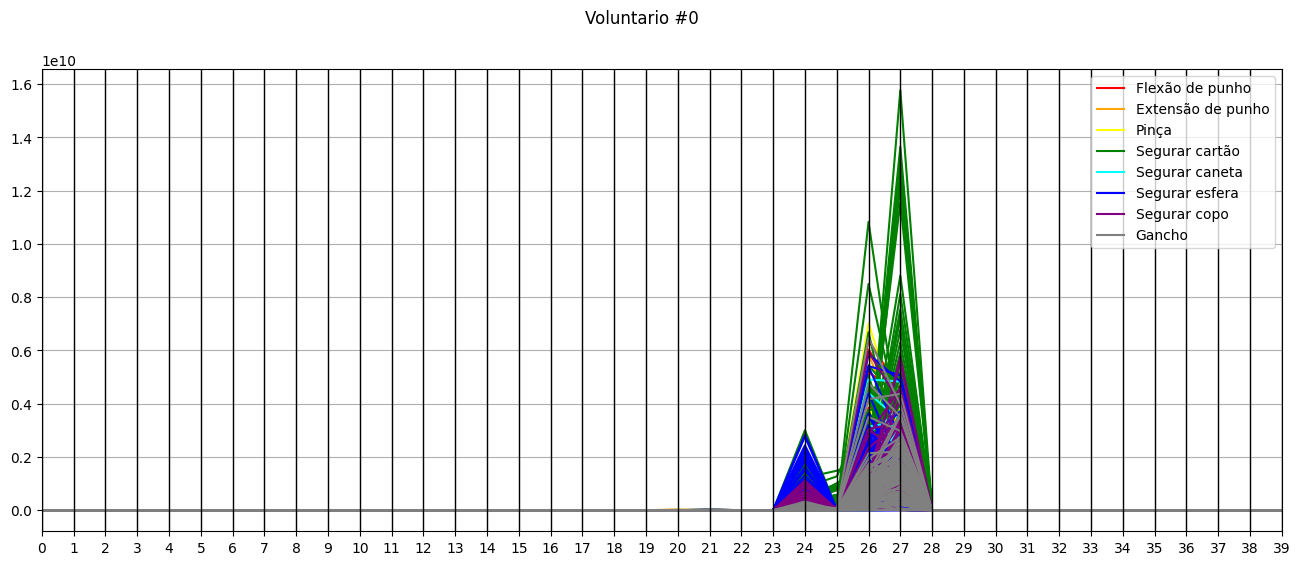

/tmp/ipykernel_14255/3534264831.py:22: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  d = [np.array(data.loc[data['classe'] == self.protocol[i]].mean()) for i in range(8)]


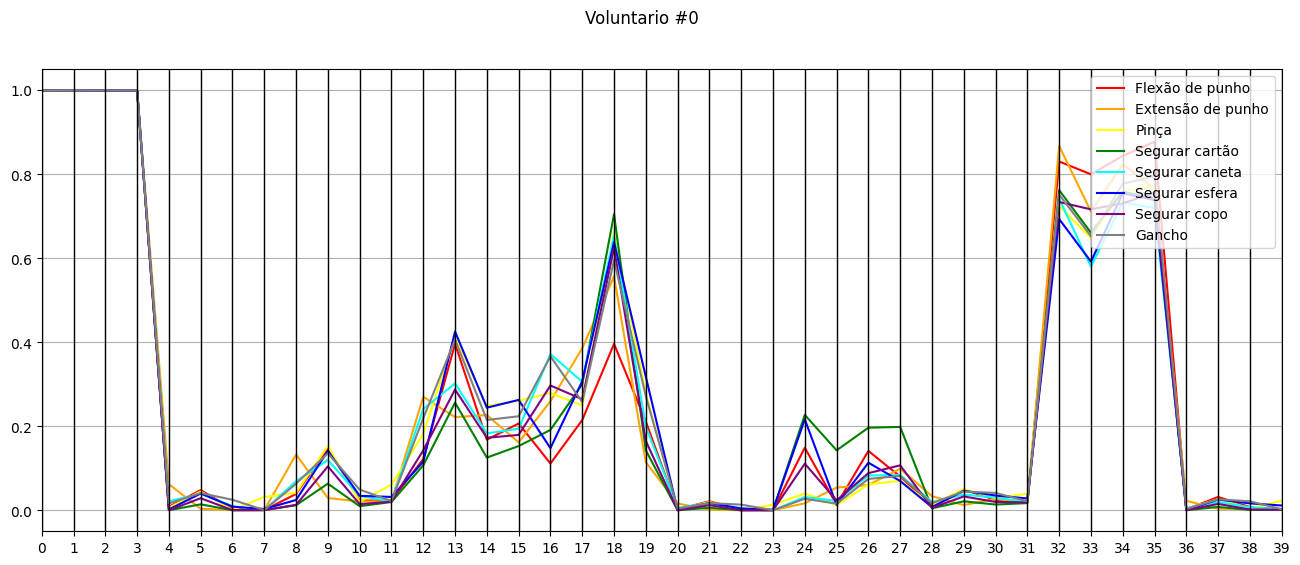

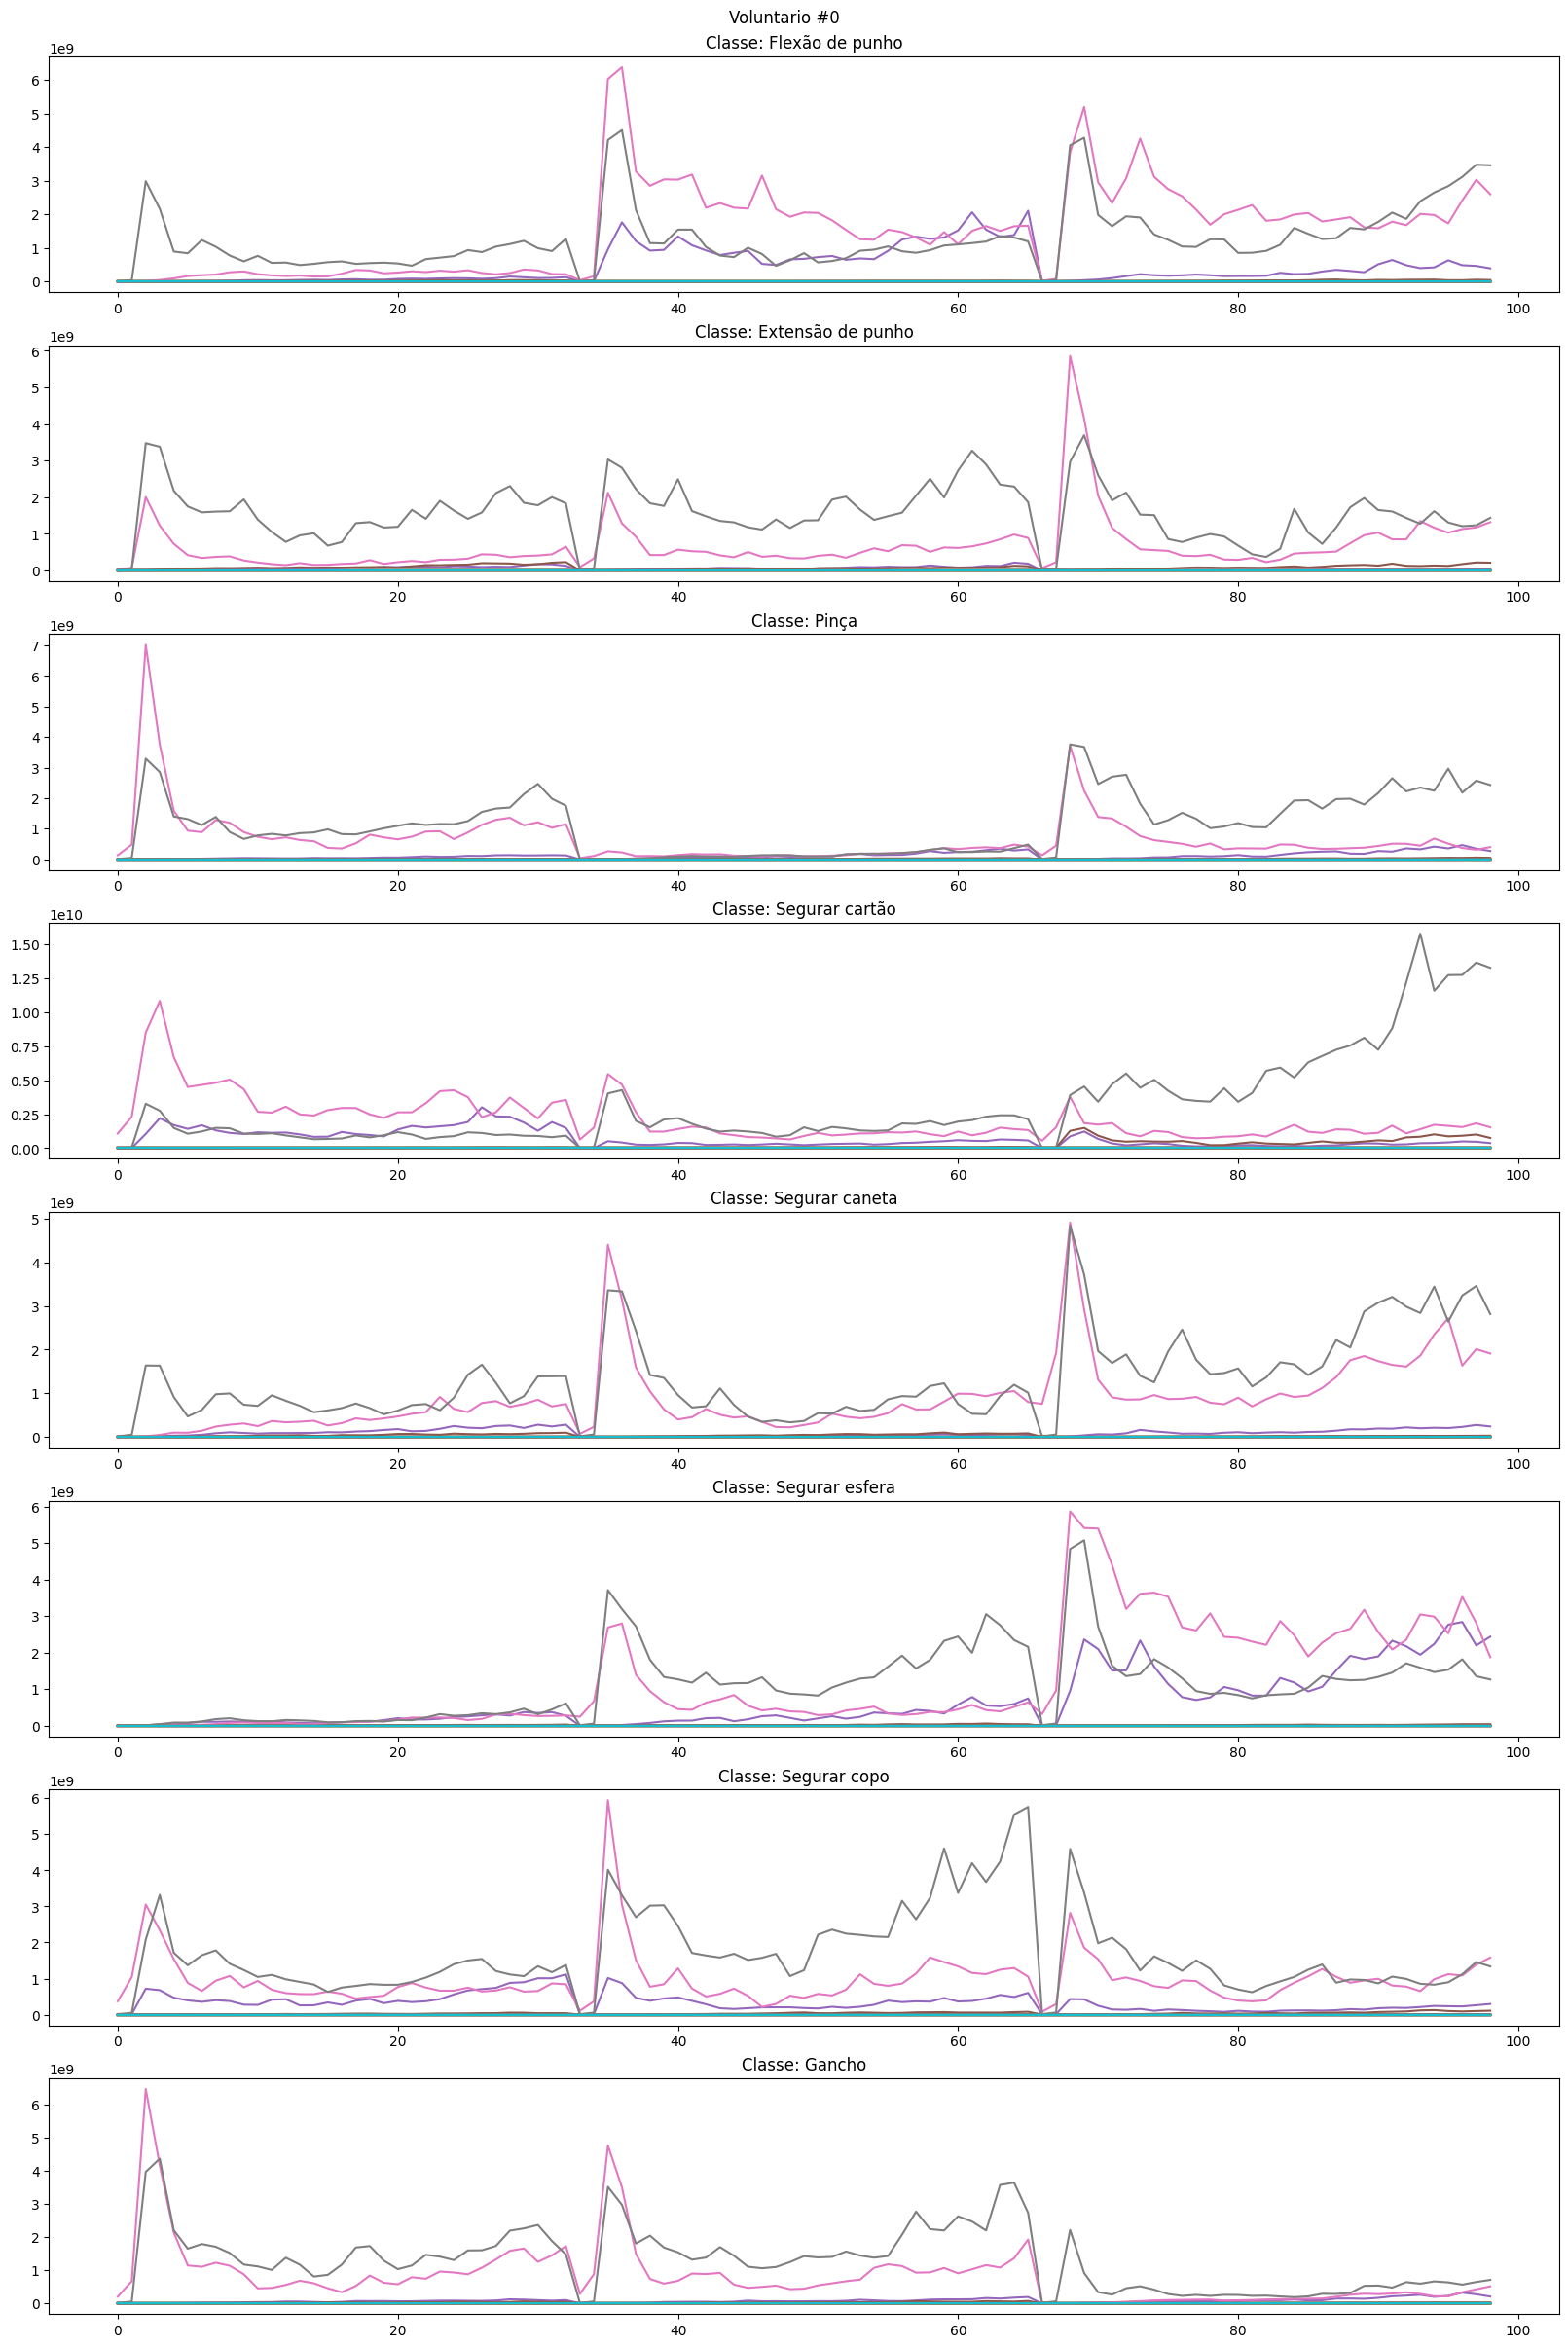

In [109]:
class PlottingVoluntarios:
    def __init__(self, voluntarios):
        self.voluntarios = voluntarios
        self.protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']

    
    def parallelCoords(self, voluntario_id, norm=False, avg=False):
        """
        Coord X = Caracteristicas
        Coord Y = Valor das Caracteristicas
        Cor = Protocolo / Tipos de Movimentos
        Linhas = Instancias (linhas da tabela)
        """
        #preprocessing
        data = np.array(self.voluntarios[voluntario_id])
        if norm: data = normalize(data, axis=0, norm='max')
        data = pd.DataFrame(data)
        data['classe'] = np.repeat(self.protocol, 99, axis=None)
        # data['classe'] = self.protocol * 99
    
        if avg:
            d = [np.array(data.loc[data['classe'] == self.protocol[i]].mean()) for i in range(8)]
            data = pd.DataFrame(d)
            data['classe'] = self.protocol
    
        #plot
        rcParams['figure.figsize'] = [16., 6.]
        colormap = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'grey']
        ax = parallel_coordinates(data, 'classe', color=colormap)
        ax.figure.suptitle(f'Voluntario #{voluntario_id}')
        # ax.figure.figsize = [16., 1.]
        plt.show()
    #end pc

    def lineGraph(self, voluntario_id, subplts=None, norm=False):
        """
        Linhas = Caracteristicas
        Coord X = Instancias (linhas da tabela)
        coord Y = Valor da característica para cada instancia (X)
        """
        #preprocessing
        vol = self.voluntarios[voluntario_id]

        if norm:
            vol = normalize(vol, axis=0, norm='max')

        #plot cfg
        if not subplts: subplts = range(len(self.protocol))
        rcParams['figure.figsize'] = [16., 3. * len(subplts)]
        fig, ax = plt.subplots(len(subplts), 1, constrained_layout=True)
        ax = ax if len(subplts) > 1 else [ax]
        # fig.figsize = [16., 3. * len(subplts)]
        fig.suptitle(f'Voluntario #{voluntario_id}')

        #plot
        for i, classe in enumerate(subplts):
            # retira dos 792 instancias somente as que a classe for "Classe" (resulta em 99 instancias)
            data = np.array([vol[e,:] for e in range(classe*99, (classe+1)*99)])
            # data = np.array([vol[e,:] for e in range(classe, vol.shape[0], 8)])

            ax[i].set_title(f'Classe: {self.protocol[i]}')
            # testamos todas faixas de instâncias para descobrir qual seria a melhor e concluímos que seria 32:36
            # 13:17 também poderia ser uma boa faixa se não fosse pela grande diferença
            ax[i].plot(data)#[:,32:36])
        plt.show()
    #end linegraph

pv = PlottingVoluntarios(voluntarios)
pv.parallelCoords(0)
pv.parallelCoords(0, norm=True, avg=True)
pv.lineGraph(0)#, subplts=[0, 3, 4])

### Métodos de Extração Automatizada de Características
Pesquisar pelo menos 2 métodos de seleção automatizada de característica. Exceto o método RFE (recursive Feature Elimination): limita o SVM posteriormente a utilizar kernel não linear.


In [110]:
# VARIANCE THRESHOLD
X = voluntarios[0]
X = normalize(X, axis=0, norm='max')
print(X.shape)

vt = VarianceThreshold(threshold=0.01)
varX = vt.fit_transform(X)
print(varX.shape)

(792, 40)
(792, 16)


In [111]:
# SELECT K BEST
X = voluntarios[0]
X = normalize(X, axis=0, norm='max')
print(X.shape)

kb = SelectKBest(f_classif, k=10)
bestX = kb.fit_transform(X, classes)
print(bestX.shape)

(792, 40)
(792, 10)


/home/caio/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/caio/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Teste com SVM simples

In [112]:
### Load instancias
X = voluntarios[3]
Y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
print(X.shape)


### Pré-processamento
X = normalize(X, axis=0, norm='max')

# vt = VarianceThreshold(threshold=0.005)
# X = vt.fit_transform(X)

kb = SelectKBest(f_classif, k=20)
X = kb.fit_transform(X, Y)


### Separar os conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
print('Treino:', x_train.shape, len(y_train))
print('Teste:', x_test.shape, len(y_test))


### SVM
clf = svm.SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print('*************************** SVM ***************************')
result = metrics.classification_report(y_test, y_pred, digits=5)
print(result)


### KNN
neigh = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print('*************************** KNN ***************************')
result = metrics.classification_report(y_test, y_pred, digits=5)
print(result)

### debug
# for i in range(len(y_test)):
#     print(f'{y_test[i]} -> {y_pred[i]}')

(792, 40)
Treino: (554, 20) 554
Teste: (238, 20) 238
*************************** SVM ***************************
                   precision    recall  f1-score   support

Extensão de punho    0.81481   0.66667   0.73333        33
  Flexão de punho    0.62162   0.76667   0.68657        30
           Gancho    0.60714   0.50000   0.54839        34
            Pinça    0.45652   0.80769   0.58333        26
   Segurar caneta    0.45455   0.40000   0.42553        25
   Segurar cartão    0.84211   0.50000   0.62745        32
     Segurar copo    0.91667   0.73333   0.81481        30
   Segurar esfera    0.51429   0.64286   0.57143        28

         accuracy                        0.62605       238
        macro avg    0.65346   0.62715   0.62386       238
     weighted avg    0.66496   0.62605   0.62929       238

*************************** KNN ***************************
                   precision    recall  f1-score   support

Extensão de punho    0.81818   0.81818   0.81818        